In [1]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import wandb
import pytorch_lightning as pl
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from source.tasks import DeepSurv

from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression
from source.wrappers import ForwardWrapper
import os
import seaborn as sns

In [2]:
RESULTS_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities'
DATA_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
EVALUATION_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation'

## Helpful functions

In [3]:
# TODO: this works if the second tag is the experiment identifier
def load_details(run):
    dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
    path = f'{dir}/{run.tags[0]}_attribute_details.csv'
    details_df = pd.read_csv(path)
    return details_df, path

def output_diff(model, orig_features, resampled_features):
    orig_output, *_ = model(orig_features)
    resampled_output, *_ = model(resampled_features)
    with torch.no_grad():
        diff = torch.sub(orig_output, resampled_output)
    return diff.detach().numpy()

def load_attributions(run, method):
    attr_x = np.genfromtxt(run.config[f'{method}_x_path'], delimiter=',')
    attr_y = np.genfromtxt(run.config[f'{method}_y_path'], delimiter=',')
    return attr_x, attr_y

def clip_norm(array):
    """
    clips top and bottom 0.5 percent, and then divide by max absolute value
    :param array: array to clip & norm
    :return: normalized array
    """
    outliers = np.percentile(array, [0.5, 99.5])
    clipped_array = np.clip(array, *outliers)
    clipped_array_norm = clipped_array / abs(clipped_array).max()
    return clipped_array_norm

# CREATE TUPLES FOR MODEL DIFF

def col2numpy(df, colname):
    """
    convert a dataframe column to a numpy array
    :param df: dataframe
    :param colname: column name to convert to numpy array
    :return:
    """
    vals = df.loc[:, colname].values.tolist()
    vals_numpy = np.array([np.array(eval(row)) for row in vals])
    return vals_numpy

def clip_norm2d(array):
    """
    clips and normalizes the array to the range of [-1, 1]
    :param array: array to be normalized
    :return: normalized array
    """
    array_norm = np.zeros((array.shape))
    for i in range(array.shape[1]):
        column = array[:, i]
        outliers = np.percentile(column, [0.5, 99.5])
        clipped_array = np.clip(column, *outliers)
        col_norm = clipped_array / abs(clipped_array).max()
        #TODO: !!!!!FIX THIS!!!!
        array_norm[:, i] = col_norm
    return  array_norm

def clip_norm1d(array):
    """
    clips and normalizes the array to the range of [-1, 1]
    :param array:  array to be normalized
    :return: normalized array
    """
    outliers = np.percentile(array, [0.5, 99.5])
    clipped_array = np.clip(array, *outliers)
    array_norm = clipped_array / abs(clipped_array).max()
    return array_norm

## Multipoint-resampling

In [4]:
def restructure_dfs(experiment_id):
    """
    Restructure details dataframe to have the resampling points as a column, also adds in a column of resampling difference
    :param experiment_id: experiment identifier to use
    :return: None -> saves the resampling dataframe as {experiment_id}_resample_[x,y].csv
    """
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})
    run = runs[0]
    print(run.tags)
    details_df, path = load_details(run)

    # NOISE X INTERVENTION
    dfx = details_df[details_df.modified_attribute == 'noise_x']
    x_colnames = [f'x_intervention{n}' for n in range(100)]
    intervention_xdf = dfx.loc[:, x_colnames]
    intervention_xdf['x_intervention'] = intervention_xdf.values.tolist()
    resampling_xdf = pd.DataFrame(dict(x_orig=dfx.x_orig, y_orig=dfx.y_orig, x_resampling=intervention_xdf.x_intervention, time=dfx.time_orig, event=dfx.event_orig))

    # Resampling difference noise_x
    orig_vals = resampling_xdf.loc[:, 'x_orig'].values
    resamp_vals = resampling_xdf.loc[:, 'x_resampling'].values.tolist()
    resamp_vals_numpy=np.array([np.array(row) for row in resamp_vals])
    orig_vals_array = np.array([[val] * 100 for val in orig_vals])
    resampling_xdf.loc[:, 'resampling_diff'] = np.absolute(orig_vals_array - resamp_vals_numpy).tolist()
    resampling_xdf.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_x.csv')

    # NOISE Y INTERVENTION
    dfy = details_df[details_df.modified_attribute == 'noise_y']
    y_colnames = [f'y_intervention{n}' for n in range(100)]
    intervention_ydf = dfy.loc[:, y_colnames]
    intervention_ydf['y_intervention'] = intervention_ydf.values.tolist()
    resampling_ydf = pd.DataFrame(dict(x_orig=dfy.x_orig, y_orig=dfy.y_orig, y_resampling=intervention_ydf.y_intervention, time=dfy.time_orig, event=dfy.event_orig))

    # Resampling difference noise_y
    orig_vals = resampling_ydf.loc[:, 'y_orig'].values
    resamp_vals = resampling_ydf.loc[:, 'y_resampling'].values.tolist()
    resamp_vals_numpy=np.array([np.array(row) for row in resamp_vals])
    orig_vals_array = np.array([[val] * 100 for val in orig_vals])
    resampling_ydf.loc[:, 'resampling_diff'] = np.absolute(orig_vals_array - resamp_vals_numpy).tolist()
    resampling_ydf.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_y.csv')

This is the saved dataframe from restructure_dfs()

In [6]:
experiment_id = 'p0.75'
pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_x.csv', index_col=0)

,x_orig,y_orig,x_resampling,time,event,resampling_diff
0,0.348720,0.389544,"[-0.3359962421121104, 0.0757522714949251, -0.8...",0.791166,1.0,"[0.6847161281312388, 0.2729676145242033, 1.215..."
1,0.784569,0.446195,"[-0.1530040531730433, 1.087602749330351, 0.819...",0.806355,1.0,"[0.9375727475942667, 0.3030340549091277, 0.034..."
2,1.209356,1.314928,"[0.9367276467400668, 0.1407234548299741, 0.212...",0.000000,0.0,"[0.2726279408110882, 1.068632132721181, 0.9970..."
3,0.233735,-0.274223,"[-1.7405027677917992, -0.5069073641056587, 0.0...",0.878572,1.0,"[1.9742376039544363, 0.7406422002682957, 0.171..."
4,-0.612208,0.822774,"[1.7694521637651923, -0.4403750472000197, -1.4...",0.920771,1.0,"[2.381660448933591, 0.17183323796837907, 0.837..."
...,...,...,...,...,...,...
5095,-2.713351,-2.496023,"[0.0105750265863676, -0.7937752253749618, -0.4...",1.142518,1.0,"[2.7239258022415243, 1.9195755502801948, 2.251..."
5096,0.309199,-0.334600,"[1.4345700560264594, 1.6163265076751128, -0.15...",0.842824,1.0,"[1.1253710448337375, 1.307127496482391, 0.4632..."
5097,0.748925,0.182532,"[-0.0265191369169419, -0.3005558763207619, 0.5...",0.307402,1.0,"[0.775444065070997, 1.049480804474817, 0.18374..."
5098,-0.567965,-0.505648,"[-0.5771746694021446, -0.4294065409476704, -1....",0.895207,1.0,"[0.00920977065479156, 0.13855835779968262, 1.1..."


## Calculate Change Slope

Now that we have the resampling dataframe with resampling_diff, orig points & resampling points we can calculate change_slope for each seed

In [7]:
def calculate_change_slope(experiment_id, method):
    """
    creates and saves a dataframe with change slope & avg change slope per point
    :param experiment_id: experiment identifier
    :param method: feature ablation method to calculate errors on
    :return:
    """

    experiment_id = experiment_id
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})

    for run in runs:
        # load resampling dataframe and model
        xdf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_x.csv', index_col=0)
        ydf = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_id}_resampling_y.csv', index_col=0)
        model = DeepSurv.load_from_checkpoint(run.config['checkpoint_path'])

        # get resampling tensors for xdf
        orig_tensor_x = torch.Tensor(xdf[['x_orig', 'y_orig']].to_numpy(dtype='float64'))
        resamp_vals = col2numpy(xdf, 'x_resampling')
        constant_val = xdf['y_orig'].to_numpy(dtype='float64')
        resamp_tensors_x = []
        for i in range(resamp_vals.shape[1]):
            # modified attribute == noise_x -> resamp_tensor = (resamp, constant)
            resamp_tensor = torch.Tensor(np.concatenate((resamp_vals[:, i].reshape(-1, 1), constant_val.reshape(-1, 1)), axis=1))
            resamp_tensors_x.append(resamp_tensor)

        # get resampling tensors for ydf
        orig_tensor_y = torch.Tensor(ydf[['x_orig', 'y_orig']].to_numpy(dtype='float64'))
        resamp_vals = col2numpy(ydf, 'y_resampling')
        constant_val = ydf['x_orig'].to_numpy(dtype='float64')
        resamp_tensors_y = []
        for i in range(resamp_vals.shape[1]):
            # modified attribute == noise_y -> resamp_tensor = (constant, resamp)
            resamp_tensor = torch.Tensor(np.concatenate((constant_val.reshape(-1, 1), resamp_vals[:, i].reshape(-1, 1)), axis=1))
            resamp_tensors_y.append(resamp_tensor)

        # CALCULATE MODEL DIFF + CHANGE SLOPE

        # load attributions
        attr_x, attr_y = load_attributions(run, method=method)
        attr_x = attr_x[:, 0]
        attr_y = attr_y[:, 1]

        orig_output = model(orig_tensor_x)[0].detach().numpy()
        resamp_outputs = None
        for i in range(resamp_vals.shape[1]):
            resamp_output = model(resamp_tensors_x[i])[0].detach().numpy()
            resamp_outputs = resamp_output if resamp_outputs is None else np.concatenate((resamp_outputs, resamp_output), axis=1)

        # calculate change slope
        model_diff = np.subtract(orig_output, resamp_outputs)
        resampling_diff = col2numpy(xdf, 'resampling_diff')
        change_slope = np.true_divide(model_diff, resampling_diff)
        mean_cs = np.mean(change_slope, axis=1)

        xdf.loc[:, 'model_diff'] = model_diff.tolist()
        xdf.loc[:, 'change_slope'] = change_slope.tolist()
        xdf.loc[:, 'mean_cs'] = mean_cs
        xdf.loc[:, 'attribution_x'] = attr_x

        # calculate change slope
        orig_output = model(orig_tensor_y)[0].detach().numpy()
        resamp_outputs = None
        for i in range(resamp_vals.shape[1]):
            resamp_output = model(resamp_tensors_y[i])[0].detach().numpy()
            resamp_outputs = resamp_output if resamp_outputs is None else np.concatenate((resamp_outputs, resamp_output), axis=1)

        model_diff = np.subtract(orig_output, resamp_outputs)
        resampling_diff = col2numpy(ydf, 'resampling_diff')
        change_slope = np.true_divide(model_diff, resampling_diff)
        mean_cs = np.mean(change_slope, axis=1)

        ydf.loc[:, 'model_diff'] = model_diff.tolist()
        ydf.loc[:, 'change_slope'] = change_slope.tolist()
        ydf.loc[:, 'mean_cs'] = mean_cs
        ydf.loc[:, 'attribution_y'] = attr_y

        # Save dataframes
        EVALUATION_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation'
        if not os.path.exists(f'{EVALUATION_DIR}/{experiment_id}'):
            os.mkdir(f'{EVALUATION_DIR}/{experiment_id}')

        if not os.path.exists(f'{EVALUATION_DIR}/{experiment_id}/change_slope'):
            os.mkdir(f'{EVALUATION_DIR}/{experiment_id}/change_slope')

        seed = eval(run.config['_content']['experiment'])['datamodule_kwargs']['seed']
        xdf.to_csv(f'{EVALUATION_DIR}/{experiment_id}/change_slope/x_{method}_{seed}.csv')
        ydf.to_csv(f'{EVALUATION_DIR}/{experiment_id}/change_slope/y_{method}_{seed}.csv')
        return xdf, ydf

Now that the change slope per seed is computed, we can aggregate the change slopes + attributions together for one correlation coefficient, clip and norm the values, and then calculate the error

In [8]:
def aggregate_errors(experiment_id, method):
    """
    Aggregate change slope across experiments, clip & norm the change slope + attribution,
    and calculate MAE and RMSE for each point
    :param experiment_id: experiment id to consider
    :param method: feature attribution method
    :return: saves dataframe
    """
    x_paths = []
    y_paths = []
    dir = os.listdir(f'{EVALUATION_DIR}/{experiment_id}/change_slope/{method}')
    for attr in dir:
        dim = attr.split('_')[0]
        seed = attr.split('_')[2]
        if dim == 'x':
            x_paths.append(f'{EVALUATION_DIR}/{experiment_id}/change_slope/{method}/{attr}')
        elif dim == 'y':
            y_paths.append(f'{EVALUATION_DIR}/{experiment_id}/change_slope/{method}/{attr}')
        else:
            print('WRONG')

    change_slopes_x = None
    attributions_x = None
    for x_path in x_paths:
        xdf = pd.read_csv(x_path, index_col=0)
        change_slope_x = pd.read_csv(x_path, index_col=0).mean_cs.to_numpy().reshape(-1, 1)
        change_slopes_x = change_slope_x if change_slopes_x is None else np.concatenate((change_slopes_x, change_slope_x), axis=1)
        attribution_x = pd.read_csv(x_path, index_col=0).attribution_x.to_numpy().reshape(-1, 1)
        attributions_x = attribution_x if attributions_x is None else np.concatenate((attributions_x, attribution_x), axis=1)

    csx_norm = clip_norm(change_slopes_x)
    attrx_norm = clip_norm(attributions_x)
    absolute_error = np.absolute(attrx_norm - csx_norm)
    squared_error = np.square(attrx_norm - csx_norm)
    mae = np.mean(absolute_error, axis=1)
    rmse = np.sqrt(np.mean(squared_error, axis=1))

    # add stuff to the dataframe
    xdf = xdf.loc[:, ['x_orig', 'y_orig']]
    xdf.loc[:, 'cs_norm'] = csx_norm.tolist()
    xdf.loc[:, 'attr_norm'] = attrx_norm.tolist()
    xdf.loc[:, 'MAE'] = mae
    xdf.loc[:, 'RMSE'] = rmse
    xdf.to_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv')
    print(f'saved {experiment_id}/MeanError_x_{method}.csv')


    change_slopes_y = None
    attributions_y = None
    for y_path in y_paths:
        ydf = pd.read_csv(y_path, index_col=0)
        change_slope_y = pd.read_csv(y_path, index_col=0).mean_cs.to_numpy().reshape(-1, 1)
        change_slopes_y = change_slope_y if change_slopes_y is None else np.concatenate((change_slopes_y, change_slope_y), axis=1)
        attribution_y = pd.read_csv(y_path, index_col=0).attribution_y.to_numpy().reshape(-1, 1)
        attributions_y = attribution_y if attributions_y is None else np.concatenate((attributions_y, attribution_y), axis=1)

    csy_norm = clip_norm(change_slopes_y)
    attry_norm = clip_norm(attributions_y)
    absolute_error = np.absolute(attry_norm - csy_norm)
    squared_error = np.square(attry_norm - csy_norm)
    mae = np.mean(absolute_error, axis=1)
    rmse = np.sqrt(np.mean(squared_error, axis=1))

    # add stuff to the dataframe
    ydf = ydf.loc[:, ['x_orig', 'y_orig']]
    ydf.loc[:, 'cs_norm'] = csy_norm.tolist()
    ydf.loc[:, 'attr_norm'] = attry_norm.tolist()
    ydf.loc[:, 'MAE'] = mae
    ydf.loc[:, 'RMSE'] = rmse
    ydf.to_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv')
    print(f'saved {experiment_id}/MeanError_y_{method}.csv')

## Inspect distributions

In [9]:
method = 'KernelExplainer'

def compare_methods(experiment_id:str, dimension:str = 'both', metric:str = 'MAE') -> pd.DataFrame:
    method = 'FeatureAblation'
    xdf_fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_fa = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_fa, ydf_fa]:
        df.loc[:, 'attribution_method'] = method

    method = 'FeaturePermutation'
    xdf_fp = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_fp = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_fp, ydf_fp]:
        df.loc[:, 'attribution_method'] = method

    method = 'KernelExplainer'
    xdf_ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_ke = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_ke, ydf_ke]:
        df.loc[:, 'attribution_method'] = method

    method = 'DeepExplainer'
    xdf_de = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_de = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_de, ydf_de]:
        df.loc[:, 'attribution_method'] = method

    method = 'IntegratedGradients'
    xdf_ig = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_ig = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_ig, ydf_ig]:
        df.loc[:, 'attribution_method'] = method

    method = 'InputXGradient'
    xdf_ixg = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_ixg = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_ixg, ydf_ixg]:
        df.loc[:, 'attribution_method'] = method

    method = 'Lime'
    xdf_lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_lime = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_lime, ydf_lime]:
        df.loc[:, 'attribution_method'] = method

    full_xdf = xdf_de.append([xdf_lime, xdf_ixg, xdf_ig, xdf_fa, xdf_ke, ], ignore_index=True)
    full_xdf.loc[:, 'modified_attribute'] = 'noise_x'
    full_ydf = ydf_de.append([ydf_lime, ydf_ixg, ydf_ig, ydf_fa, ydf_ke, ], ignore_index=True)
    full_ydf.loc[:, 'modified_attribute'] = 'noise_y'
    full_df = full_xdf.append(full_ydf, ignore_index=True)

    full_df = full_xdf if dimension=='x' else full_ydf if dimension=='y' else full_xdf.append(full_ydf, ignore_index=True)
    sns.set(rc={'figure.figsize':(20,10)})
    sns.violinplot(data=full_df,
                   x='attribution_method',
                   y=metric,
                   split=True,
                   scale='count',
                   inner='quartile',
                   hue='modified_attribute',
                   palette='Spectral_r')
    plt.ylim(-0.20, 1.8)
    plt.suptitle(experiment_id)
    return full_df


def plot_distributions(method):
    experiment_id = 'p0.75'
    xdf_75 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_75 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_75, ydf_75]:
        df.loc[:, 'correlation_coefficient'] = 0.75

    experiment_id = 'p0.5'
    xdf_50 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_50 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_50, ydf_50]:
        df.loc[:, 'correlation_coefficient'] = 0.50

    experiment_id = 'p0.25'
    xdf_25 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_25 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_25, ydf_25]:
        df.loc[:, 'correlation_coefficient'] = 0.25

    experiment_id = 'p0.00'
    xdf_00 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv', index_col=0)
    ydf_00 = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv', index_col=0)
    for df in [xdf_00, ydf_00]:
        df.loc[:, 'correlation_coefficient'] = 0.00

    full_xdf = xdf_75.append([xdf_00, xdf_25, xdf_50], ignore_index=True)
    full_xdf.loc[:, 'modified_attribute'] = 'noise_x'
    full_ydf = ydf_75.append([xdf_00, ydf_25, ydf_50], ignore_index=True)
    full_ydf.loc[:, 'modified_attribute'] = 'noise_y'
    full_df = full_xdf.append(full_ydf, ignore_index=True)
    sns.set(rc={'figure.figsize':(20,10)})
    sns.displot(data=full_df,
                x='MAE',
                hue="correlation_coefficient",
                col='modified_attribute',
                fill=True,
                kind='kde',
                palette='crest',
                alpha=0.1,
                linewidth=2.0,
                legend=True)
    plt.xlim(-0.10, 2.0)
    plt.ylim(0.00, 1.2)
    plt.suptitle(method, y=0.99, x=0.45)

,x_orig,y_orig,cs_norm,attr_norm,MAE,RMSE,attribution_method,modified_attribute
0,-0.357935,-1.341264,"[-0.07291266736497434, -0.09757353479942331, -...","[-0.11230218171788273, -0.09392160898426881, -...",0.036249,0.042870,DeepExplainer,noise_x
1,0.160997,0.414187,"[0.14273754324779767, 0.07550865815560344, 0.1...","[0.04987236549220915, 0.049924566477400685, 0....",0.063888,0.072631,DeepExplainer,noise_x
2,-1.674679,-0.536504,"[-0.7231791220605569, -0.5877929704340833, -0....","[-0.5496272382566949, -0.4361600956037194, -0....",0.171942,0.187056,DeepExplainer,noise_x
3,-0.485223,-0.182719,"[-0.18189408633525148, -0.19857917442660145, -...","[-0.14310605622082986, -0.1251692616204966, -0...",0.044744,0.048404,DeepExplainer,noise_x
4,1.465296,0.588396,"[0.5831246253665582, 0.6723518191632394, 0.658...","[0.469793646545213, 0.5563516146842561, 0.5742...",0.117033,0.128734,DeepExplainer,noise_x
...,...,...,...,...,...,...,...,...
60595,1.125747,0.524230,"[-0.11317156019787013, -0.10978281213751087, -...","[0.17936993819564231, 0.17472254256271427, 0.1...",0.244583,0.259047,KernelExplainer,noise_y
60596,-1.999972,1.641878,"[0.05558449021417559, 0.05721168273360128, 0.0...","[0.550651488621864, 0.5431231478154521, 0.5735...",0.427434,0.455334,KernelExplainer,noise_y
60597,0.291917,-0.595349,"[-0.10732520126336421, -0.10517499044046379, -...","[-0.17343662921504382, -0.17000179377450975, -...",0.049458,0.054303,KernelExplainer,noise_y
60598,2.185078,-1.463686,"[0.14641998284938978, 0.13538266259600865, 0.1...","[-0.4868228856234128, -0.46791173232389177, -0...",0.527923,0.559512,KernelExplainer,noise_y


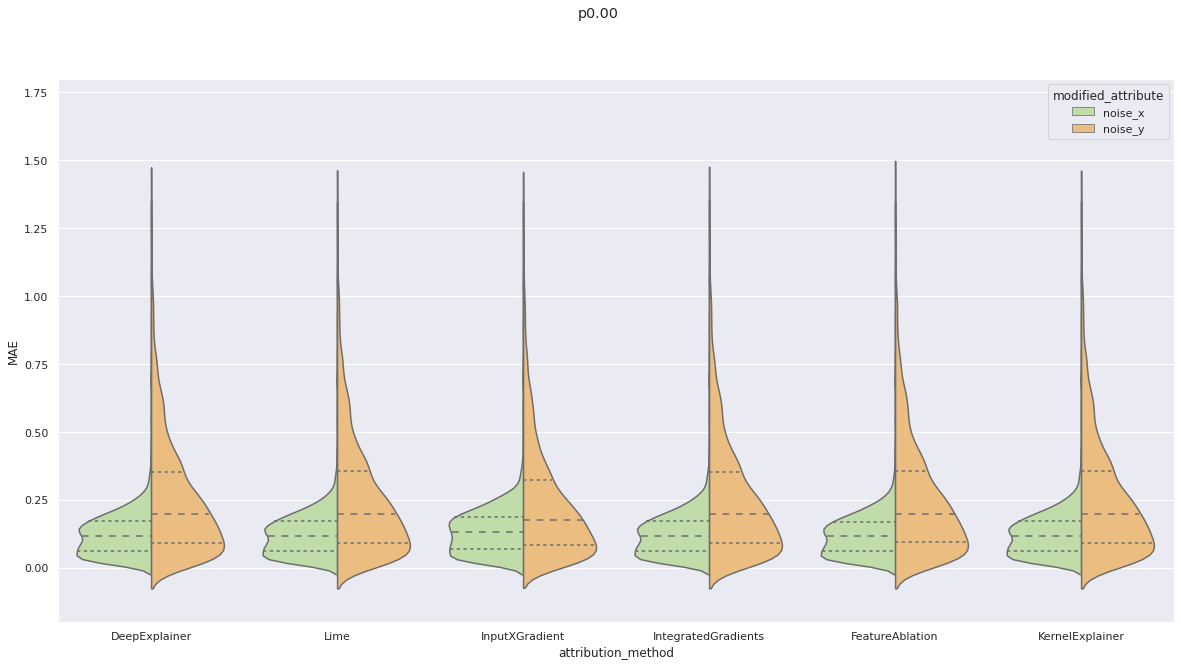

In [10]:
compare_methods('p0.00', dimension='both', metric='MAE')

,x_orig,y_orig,cs_norm,attr_norm,MAE,RMSE,attribution_method,modified_attribute
0,0.348720,0.389544,"[0.022823815233955182, 0.03317227359818295, 0....","[0.09764566881695867, 0.0867224802845824, 0.10...",0.079623,0.083121,DeepExplainer,noise_x
1,0.784569,0.446195,"[0.03372494806110577, 0.042572160060133875, 0....","[0.22993179090277183, 0.19444597167797445, 0.2...",0.208927,0.217420,DeepExplainer,noise_x
2,1.209356,1.314928,"[0.0757325581717608, 0.060378096946878734, 0.0...","[0.37641342085961405, 0.2920838245785245, 0.33...",0.323673,0.336632,DeepExplainer,noise_x
3,0.233735,-0.274223,"[0.044734315834190436, 0.056687007469036314, 0...","[0.06431503843980355, 0.05948982343590089, 0.0...",0.018582,0.022487,DeepExplainer,noise_x
4,-0.612208,0.822774,"[-0.11914258188416184, -0.10420517565257592, -...","[-0.1735430714742824, -0.16291257899100242, -0...",0.069887,0.079601,DeepExplainer,noise_x
...,...,...,...,...,...,...,...,...
60595,0.820011,-0.339785,"[0.21838037963016893, 0.21998554702417908, 0.1...","[-0.12378396410168813, -0.12548329461509689, -...",0.276356,0.285458,KernelExplainer,noise_y
60596,-1.639622,-1.851417,"[0.39001762612895663, 0.362796380223376, 0.356...","[-0.8181618328586254, -0.810396886014082, -0.8...",0.893520,0.930603,KernelExplainer,noise_y
60597,1.218561,1.083832,"[0.27185602636025064, 0.2606338941137688, 0.20...","[0.3970377567294834, 0.39220859711064254, 0.33...",0.080396,0.088365,KernelExplainer,noise_y
60598,1.644935,0.250605,"[0.048504450881130576, 0.03820242070114062, 0....","[0.0861212891482531, 0.08689647517056116, 0.07...",0.029050,0.031460,KernelExplainer,noise_y


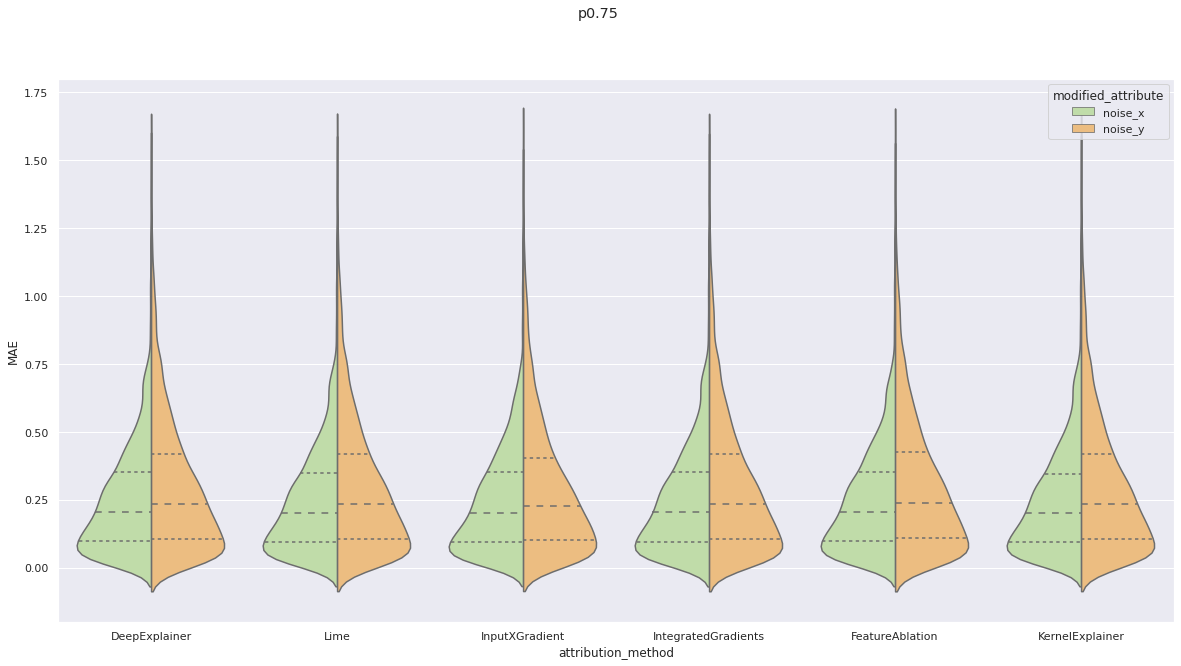

In [11]:
compare_methods('p0.75', dimension='both', metric='MAE')

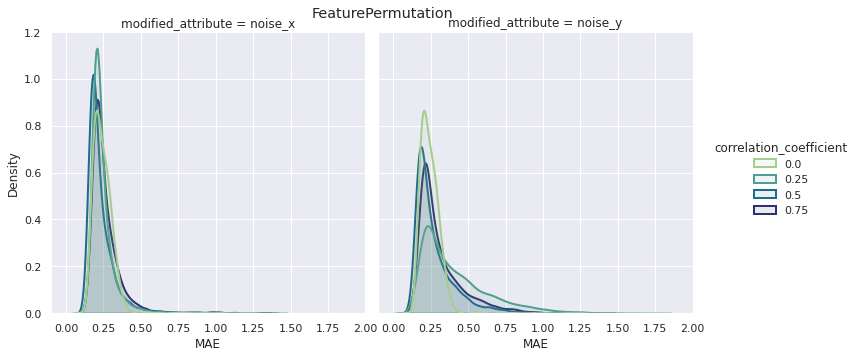

In [67]:
plot_distributions('FeaturePermutation')

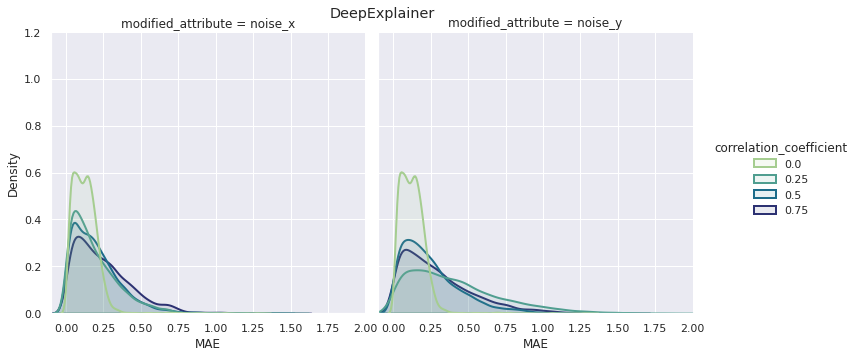

In [68]:
plot_distributions('DeepExplainer')

In [114]:
methods = ['FeatureAblation',
              'FeaturePermutation',
              'InputXGradient',
              'IntegratedGradients',
              'Lime',
              'KernelExplainer',
              'DeepExplainer']
experiment_ids = ['p0.00', 'p0.25', 'p0.5', 'p0.75']
for method in methods:
    for experiment_id in experiment_ids:
        aggregate_errors(experiment_id, method)

saved p0.00/MeanError_x_FeatureAblation.csv
saved p0.00/MeanError_y_FeatureAblation.csv
saved p0.25/MeanError_x_FeatureAblation.csv
saved p0.25/MeanError_y_FeatureAblation.csv
saved p0.5/MeanError_x_FeatureAblation.csv
saved p0.5/MeanError_y_FeatureAblation.csv
saved p0.75/MeanError_x_FeatureAblation.csv
saved p0.75/MeanError_y_FeatureAblation.csv
saved p0.00/MeanError_x_FeaturePermutation.csv
saved p0.00/MeanError_y_FeaturePermutation.csv
saved p0.25/MeanError_x_FeaturePermutation.csv
saved p0.25/MeanError_y_FeaturePermutation.csv
saved p0.5/MeanError_x_FeaturePermutation.csv
saved p0.5/MeanError_y_FeaturePermutation.csv
saved p0.75/MeanError_x_FeaturePermutation.csv
saved p0.75/MeanError_y_FeaturePermutation.csv
saved p0.00/MeanError_x_InputXGradient.csv
saved p0.00/MeanError_y_InputXGradient.csv
saved p0.25/MeanError_x_InputXGradient.csv
saved p0.25/MeanError_y_InputXGradient.csv
saved p0.5/MeanError_x_InputXGradient.csv
saved p0.5/MeanError_y_InputXGradient.csv
saved p0.75/MeanErro

<AxesSubplot:xlabel='x_orig', ylabel='y_orig'>

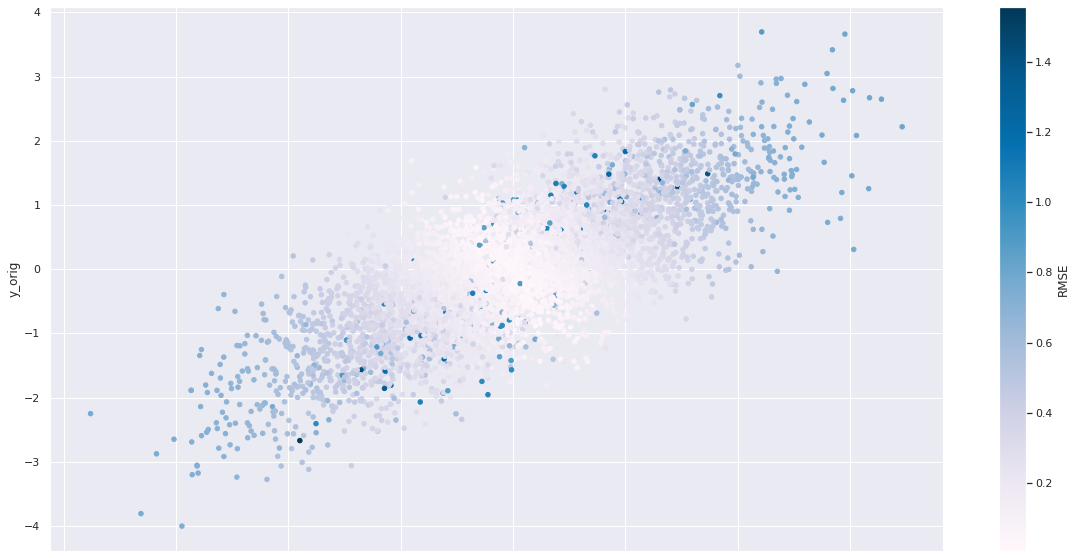

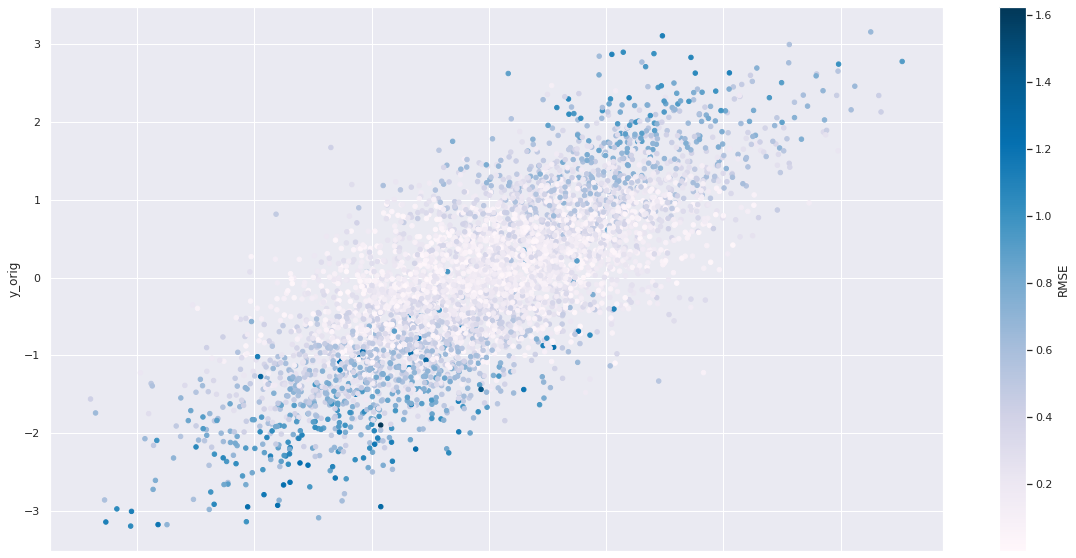

In [80]:
experiment_id = 'p0.75'
method = 'KernelExplainer'
xdf = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_x_{method}.csv')
ydf = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/MeanError_y_{method}.csv')
xdf.plot.scatter('x_orig', 'y_orig', c='RMSE', cmap='PuBu')
ydf.plot.scatter('x_orig', 'y_orig', c='RMSE', cmap='PuBu')

In [81]:
csx_norm = clip_norm(change_slopes_x)
attrx_norm = clip_norm(attributions_x)

In [82]:
csx_norm

array([[-0.07905711, -0.06544421, -0.05552967, ..., -0.09757353,
        -0.06107372, -0.02961171],
       [ 0.10675816,  0.12991908,  0.04107794, ...,  0.07550866,
         0.14748864,  0.05770483],
       [-0.70307095, -0.7514203 , -0.31227737, ..., -0.58779297,
        -0.83662456, -0.30486732],
       ...,
       [-0.00223998,  0.01775707, -0.01434088, ..., -0.03165219,
         0.04495592,  0.00193486],
       [-0.39554449, -0.40767205, -0.17822267, ..., -0.36137426,
        -0.43037066, -0.16695173],
       [ 0.18985099,  0.21035725,  0.072323  , ...,  0.15926018,
         0.21497713,  0.09095484]])

In [84]:
attrx_norm

array([[-0.11715168, -0.1219948 , -0.04227745, ..., -0.09402683,
        -0.13690937, -0.03577719],
       [ 0.05618001,  0.05443786,  0.01768752, ...,  0.05051777,
         0.05259359,  0.01886778],
       [-0.55886988, -0.58658926, -0.18562497, ..., -0.43318431,
        -0.65008644, -0.18421684],
       ...,
       [ 0.0054403 ,  0.00552379,  0.00195647, ...,  0.00457474,
         0.00593867,  0.00174983],
       [-0.3042021 , -0.31343008, -0.10288002, ..., -0.24890725,
        -0.3369984 , -0.10324077],
       [ 0.11220087,  0.10686729,  0.03343981, ...,  0.10234173,
         0.10113275,  0.03676662]])